In [1]:
!pip3 install xgboost
!pip install decision-tree-morfist

In [2]:
import config
import ast

import pandas as pd
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import statistics

from utils.pandas_dataframe import grid_display
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from itertools import permutations
import gc

# validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from morfist import MixedRandomForest

# grid search
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.model_selection import GridSearchCV


from sklearn.multioutput import RegressorChain
from sklearn.multioutput import MultiOutputRegressor

from IPython.display import display


%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format',lambda x: '%.2f' % x)
# pd.set_option('display.max_rows', 5)
pd.set_option('display.max_rows', None)

In [4]:
data = pd.read_excel('../Data/2022-train-v2.xlsx')

In [5]:
print(f"train shape : {data.shape}")

train shape : (635, 131)


In [6]:
data_y = data[['sensor_point5_i_value', 'sensor_point6_i_value',\
               'sensor_point7_i_value', 'sensor_point8_i_value',\
               'sensor_point9_i_value', 'sensor_point10_i_value']]
data_x = data.drop(['sensor_point5_i_value', 'sensor_point6_i_value',\
                    'sensor_point7_i_value', 'sensor_point8_i_value',\
                    'sensor_point9_i_value', 'sensor_point10_i_value'], axis=1)

In [7]:
def Col_types(Data):
    Column_types = Data.dtypes.to_frame().reset_index()
    Column_types.columns = ['ColumnName', 'Type']
    Column_types.sort_values( by= 'Type', inplace = True)
    return Column_types

def Missing_Counts(Data):
    missing = Data.isnull().sum()
    missing = missing[ missing >0]
    missing.sort_values( inplace=True)
    Missing_Count = pd.DataFrame({ 'ColumnName':missing.index, 'MissingCount':missing.values})
    Missing_Count['Percentage(%)'] = Missing_Count['MissingCount'].apply(lambda x:round(x/Data.shape[0]*100,2))
    return Missing_Count

### 檢查缺失值

In [8]:
display(Missing_Counts(data_x))

,ColumnName,MissingCount,Percentage(%)
0,clean_ph4,286,45.04
1,clean_ph5,286,45.04
2,clean_ph7,286,45.04


In [9]:
display(Missing_Counts(data_y))

,ColumnName,MissingCount,Percentage(%)


In [10]:
data_x = data_x.fillna(0)

### 檢查資料屬性

In [11]:
display(Col_types(data_x))

,ColumnName,Type
0,clean_temp,float64
90,painting_g11_act_hvv,float64
89,painting_g11_act_t_air,float64
88,painting_g11_act_f_air,float64
87,painting_g11_act_a_air,float64
86,painting_g10_act_hvc,float64
85,painting_g10_act_hvv,float64
84,painting_g10_act_t_air,float64
83,painting_g10_act_f_air,float64
82,painting_g10_act_a_air,float64


# 1.X變數標準化

In [12]:
# X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, train_size = 0.8, random_state = 3)

# X變數標準化
scaler = StandardScaler().fit(data_x)
data_x_S = scaler.transform(data_x)

# 2.迴圈計算每個Y在每個模型下的最佳超參數，並計算RMSE值

In [13]:
# 分別計算每個Model的最佳超參數及RMSE，以判斷6個 Y的最佳 Model
# model(含超參數設定)
Lasso_params_list = []
Ridge_params_list = []
XGB_params_list = []
KN_params_list = []
Ada_params_list = []

# K-fold RMSE
Lasso_RMSE = []
Ridge_RMSE = []
XGB_RMSE = []
KN_RMSE = []
Ada_RMSE = []

Model_result = pd.DataFrame({})

for i in range(6):

# Gridsearch超參數範圍
  

# 1. Lasso_model
    config.Lassocv.fit(data_x_S, data_y.iloc[:,i])

    poly_Lasso_reg = Pipeline([('poly', PolynomialFeatures(degree = 2)),
                               ('std_scaler', StandardScaler()),
                               ('lasso_reg', Lasso(alpha = config.Lassocv.alpha_))
                              ])
    
    Lasso_params_list.append({'alpha':config.Lassocv.alpha_})
    
    # 訓練模型，計算train, test的RMSE
    Lasso_RMSE.append(-cross_val_score(poly_Lasso_reg, 
                                      data_x, data_y.iloc[:,i], 
                                      cv = 5, 
                                      scoring = 'neg_root_mean_squared_error').mean())
    
    poly_Lasso_reg.fit(data_x, data_y.iloc[:,i])
    

# 2. Ridge_model
    # Ridge超參數

    config.Ridgecv.fit(data_x_S, data_y.iloc[:,i])
    poly_Ridge_reg = Pipeline([('poly', PolynomialFeatures(degree = 2)),
                               ('std_scaler', StandardScaler()),
                               ('lasso_reg', Ridge(alpha = config.Ridgecv.alpha_))
                              ])
    
    Ridge_params_list.append({'alpha':config.Ridgecv.alpha_})
    
    # 訓練模型，計算train, test的RMSE
    Ridge_RMSE.append(-cross_val_score(poly_Ridge_reg, 
                                      data_x, data_y.iloc[:,i], 
                                      cv = 5, 
                                      scoring = 'neg_root_mean_squared_error').mean())
    
    poly_Ridge_reg.fit(data_x, data_y.iloc[:,i])

# 3. XGB_model
    # XGBM超參數
    config.grid_search_xgbm.fit(data_x_S, data_y.iloc[:,i])
    
    poly_XGB_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                            ('std_scaler', StandardScaler()),
                            ('xgb_reg', xgb.XGBRegressor(**config.grid_search_xgbm.best_params_))
                            ])
    
    XGB_params_list.append(config.grid_search_xgbm.best_params_)
    # 訓練模型，計算train, test的RMSE
    

    XGB_RMSE.append(-cross_val_score(poly_XGB_reg, 
                                    data_x, data_y.iloc[:,i], 
                                    cv = 5, 
                                    scoring = 'neg_root_mean_squared_error').mean())
    
    poly_XGB_reg.fit(data_x, data_y.iloc[:,i])


# 4. KN_model
    # KN超參數

    config.grid_search_KN.fit(data_x_S, data_y.iloc[:,i])

    poly_KN_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(**config.grid_search_KN.best_params_))
                        ])
    
    KN_params_list.append(config.grid_search_KN.best_params_)
    # 訓練模型，計算train, test的RMSE
    
    KN_RMSE.append(-cross_val_score(poly_KN_reg, 
                                    data_x, data_y.iloc[:,i], 
                                    cv = 5, 
                                    scoring = 'neg_root_mean_squared_error').mean())
    
    poly_KN_reg.fit(data_x, data_y.iloc[:,i])    

# 5. Ada_model

    config.grid_search_Ada.fit(data_x_S, data_y.iloc[:,i])

    poly_Ada_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                             ('std_scaler', StandardScaler()),
                             ('Ada', AdaBoostRegressor(**config.grid_search_Ada.best_params_))
                            ]) 
    
    Ada_params_list.append(config.grid_search_Ada.best_params_)
    
    # 訓練模型，計算train, test的RMSE
    Ada_RMSE.append(-cross_val_score(poly_Ada_reg, 
                                     data_x, data_y.iloc[:,i], 
                                     cv = 5, 
                                     scoring = 'neg_root_mean_squared_error').mean())
    
    poly_Ada_reg.fit(data_x, data_y.iloc[:,i])        
    
    
# **各模型預測結果放入Model_result
    
    Model_result['Actual_'+ data_y.columns.tolist()[i]] = data_y.iloc[:,i]
    Model_result['Lasso_'+ data_y.columns.tolist()[i]] = poly_Lasso_reg.predict(data_x)
    Model_result['Ridge_'+ data_y.columns.tolist()[i]] = poly_Ridge_reg.predict(data_x)
    Model_result['XGB_'+ data_y.columns.tolist()[i]] = poly_XGB_reg.predict(data_x)
    Model_result['KN_'+ data_y.columns.tolist()[i]] = poly_KN_reg.predict(data_x)
    Model_result['Ada_'+ data_y.columns.tolist()[i]] = poly_Ada_reg.predict(data_x)    

# list 串接成 pandas表格    
Model_RMSE = pd.DataFrame({'Lasso':Lasso_params_list,
                           'Lasso_RMSE':Lasso_RMSE,
                           'Ridge':Ridge_params_list,
                           'Ridge_RMSE':Ridge_RMSE,
                           'XGB':XGB_params_list,
                           'XGB_RMSE':XGB_RMSE,
                           'KN':KN_params_list,
                           'KN_RMSE':KN_RMSE,
                           'Ada':Ada_params_list,
                           'Ada_RMSE':Ada_RMSE
                          }, index = list(data_y.columns))

display(Model_RMSE)
display(Model_result)

# 資料輸出到Excel檔案
output = pd.ExcelWriter('../Data/output.xlsx')
Model_RMSE.to_excel(output, sheet_name = 'Model_RMSE',index = False)
Model_result.to_excel(output, sheet_name = 'Model_result',index = False)

output.save()

,Lasso,Lasso_RMSE,Ridge,Ridge_RMSE,XGB,XGB_RMSE,KN,KN_RMSE,Ada,Ada_RMSE
sensor_point5_i_value,{'alpha': 5.0},13.56,{'alpha': 500.0},17.63,"{'learning_rate': 0.2, 'max_depth': 5, 'min_ch...",14.82,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",14.35,"{'learning_rate': 0.2, 'n_estimators': 300}",13.72
sensor_point6_i_value,{'alpha': 1.0},29.61,{'alpha': 500.0},31.21,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",25.79,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",31.24,"{'learning_rate': 0.5, 'n_estimators': 300}",28.42
sensor_point7_i_value,{'alpha': 1.0},27.46,{'alpha': 100.0},51.44,"{'learning_rate': 0.2, 'max_depth': 13, 'min_c...",25.26,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",25.38,"{'learning_rate': 0.5, 'n_estimators': 50}",24.65
sensor_point8_i_value,{'alpha': 1.0},26.11,{'alpha': 500.0},36.44,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",23.92,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",23.26,"{'learning_rate': 0.5, 'n_estimators': 50}",23.54
sensor_point9_i_value,{'alpha': 500.0},22.14,{'alpha': 100.0},29.81,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",21.89,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",20.57,"{'learning_rate': 0.5, 'n_estimators': 300}",23.07
sensor_point10_i_value,{'alpha': 1.0},23.79,{'alpha': 500.0},37.98,"{'learning_rate': 0.2, 'max_depth': 5, 'min_ch...",18.30,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",17.88,"{'learning_rate': 0.5, 'n_estimators': 300}",17.82


,Actual_sensor_point5_i_value,Lasso_sensor_point5_i_value,Ridge_sensor_point5_i_value,XGB_sensor_point5_i_value,KN_sensor_point5_i_value,Ada_sensor_point5_i_value,Actual_sensor_point6_i_value,Lasso_sensor_point6_i_value,Ridge_sensor_point6_i_value,XGB_sensor_point6_i_value,...,Ridge_sensor_point9_i_value,XGB_sensor_point9_i_value,KN_sensor_point9_i_value,Ada_sensor_point9_i_value,Actual_sensor_point10_i_value,Lasso_sensor_point10_i_value,Ridge_sensor_point10_i_value,XGB_sensor_point10_i_value,KN_sensor_point10_i_value,Ada_sensor_point10_i_value
0,42,72.88,43.96,42.66,46.43,46.29,56,67.48,61.75,55.98,...,73.76,72.43,73.00,65.71,45,56.58,48.61,45.02,45.00,46.63
1,37,72.88,37.28,37.99,40.00,45.00,60,67.23,61.33,61.16,...,67.45,67.28,67.33,65.71,42,56.51,43.19,42.66,42.00,46.63
2,35,72.88,37.28,37.99,40.00,45.00,66,67.23,61.33,61.16,...,67.45,67.28,67.33,65.71,45,56.51,43.19,42.66,42.00,46.63
3,37,72.88,37.28,37.99,40.00,45.00,58,67.23,61.33,61.16,...,67.45,67.28,67.33,65.71,39,56.51,43.19,42.66,42.00,46.63
4,57,72.90,48.31,48.31,46.43,49.07,78,69.30,67.00,70.47,...,60.67,61.22,61.25,65.71,65,55.76,54.25,56.48,58.00,52.35
5,42,72.90,48.31,48.31,46.43,49.07,72,69.30,67.00,70.47,...,60.67,61.22,61.25,65.71,64,55.76,54.25,56.48,58.00,52.35
6,48,72.90,48.31,48.31,46.43,49.07,72,69.30,67.00,70.47,...,60.67,61.22,61.25,65.71,48,55.76,54.25,56.48,58.00,52.35
7,49,72.90,48.31,48.31,46.43,49.07,60,69.30,67.00,70.47,...,60.67,61.22,61.25,65.71,55,55.76,54.25,56.48,58.00,52.35
8,41,72.91,46.70,43.59,46.86,47.72,72,69.68,67.79,70.77,...,66.84,64.30,64.50,65.71,60,56.47,55.85,59.97,60.00,49.95
9,46,72.91,46.70,43.59,46.86,47.72,70,69.68,67.79,70.77,...,66.84,64.30,64.50,65.71,60,56.47,55.85,59.97,60.00,49.95


In [14]:
# 讀取結果檔案

Model_RMSE = pd.read_excel('../Data/output.xlsx','Model_RMSE')
Model_result = pd.read_excel('../Data/output.xlsx','Model_result')
Model_RMSE.index = [data_y.columns]
Model_RMSE

,Lasso,Lasso_RMSE,Ridge,Ridge_RMSE,XGB,XGB_RMSE,KN,KN_RMSE,Ada,Ada_RMSE
sensor_point5_i_value,{'alpha': 5.0},13.56,{'alpha': 500.0},17.63,"{'learning_rate': 0.2, 'max_depth': 5, 'min_ch...",14.82,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",14.35,"{'learning_rate': 0.2, 'n_estimators': 300}",13.72
sensor_point6_i_value,{'alpha': 1.0},29.61,{'alpha': 500.0},31.21,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",25.79,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",31.24,"{'learning_rate': 0.5, 'n_estimators': 300}",28.42
sensor_point7_i_value,{'alpha': 1.0},27.46,{'alpha': 100.0},51.44,"{'learning_rate': 0.2, 'max_depth': 13, 'min_c...",25.26,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",25.38,"{'learning_rate': 0.5, 'n_estimators': 50}",24.65
sensor_point8_i_value,{'alpha': 1.0},26.11,{'alpha': 500.0},36.44,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",23.92,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",23.26,"{'learning_rate': 0.5, 'n_estimators': 50}",23.54
sensor_point9_i_value,{'alpha': 500.0},22.14,{'alpha': 100.0},29.81,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",21.89,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",20.57,"{'learning_rate': 0.5, 'n_estimators': 300}",23.07
sensor_point10_i_value,{'alpha': 1.0},23.79,{'alpha': 500.0},37.98,"{'learning_rate': 0.2, 'max_depth': 5, 'min_ch...",18.30,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",17.88,"{'learning_rate': 0.5, 'n_estimators': 300}",17.82


In [42]:
# 各Y變數依據k-fold計算的 RMSE挑選最佳的Model(RMSE最小)
for i in range(6):
    Y_var = Model_RMSE[['Lasso_RMSE','Ridge_RMSE','XGB_RMSE','KN_RMSE','Ada_RMSE']].iloc[i,:]
    Y_var = Y_var[Y_var == Y_var.min()].index[0]
    print(data_y.columns[i] +'_best model:' + Y_var)

sensor_point5_i_value_best model:Lasso_RMSE
sensor_point6_i_value_best model:XGB_RMSE
sensor_point7_i_value_best model:XGB_RMSE
sensor_point8_i_value_best model:Ada_RMSE
sensor_point9_i_value_best model:KN_RMSE
sensor_point10_i_value_best model:XGB_RMSE


In [43]:
# 將最佳params轉成 dict型態

model_name = ['XGB','Ridge','Lasso','Ada','KN']
for m in model_name:
    # select model
    model_dict = Model_RMSE.loc[:,m].to_dict()
    for i in range(6):
        # 修改 key(如果資料匯入時index沒有帶入，將Key值轉為Y 變數欄位名稱)
        model_dict[data_y.columns[i]] = model_dict.pop(Model_RMSE.index[i])
        
        # 修改 value，將字串轉換成資料類型
        model_dict[data_y.columns[i]] = ast.literal_eval(model_dict[data_y.columns[i]])

    display('model:' + m, 'params:' + str(model_dict))

'model:XGB'

"params:{'sensor_point5_i_value': {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 30}, 'sensor_point6_i_value': {'learning_rate': 0.2, 'max_depth': 20, 'min_child_weight': 10, 'n_estimators': 30}, 'sensor_point7_i_value': {'learning_rate': 0.2, 'max_depth': 13, 'min_child_weight': 10, 'n_estimators': 30}, 'sensor_point8_i_value': {'learning_rate': 0.2, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 500}, 'sensor_point9_i_value': {'learning_rate': 0.2, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 30}, 'sensor_point10_i_value': {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 30}}"

'model:Ridge'

"params:{'sensor_point5_i_value': {'alpha': 500.0}, 'sensor_point6_i_value': {'alpha': 500.0}, 'sensor_point7_i_value': {'alpha': 100.0}, 'sensor_point8_i_value': {'alpha': 500.0}, 'sensor_point9_i_value': {'alpha': 500.0}, 'sensor_point10_i_value': {'alpha': 500.0}}"

'model:Lasso'

"params:{'sensor_point5_i_value': {'alpha': 1.0}, 'sensor_point6_i_value': {'alpha': 5.0}, 'sensor_point7_i_value': {'alpha': 1.0}, 'sensor_point8_i_value': {'alpha': 5.0}, 'sensor_point9_i_value': {'alpha': 7.0}, 'sensor_point10_i_value': {'alpha': 7.0}}"

'model:Ada'

"params:{'sensor_point5_i_value': {'learning_rate': 0.5, 'n_estimators': 500}, 'sensor_point6_i_value': {'learning_rate': 0.2, 'n_estimators': 300}, 'sensor_point7_i_value': {'learning_rate': 0.2, 'n_estimators': 300}, 'sensor_point8_i_value': {'learning_rate': 0.2, 'n_estimators': 50}, 'sensor_point9_i_value': {'learning_rate': 0.2, 'n_estimators': 50}, 'sensor_point10_i_value': {'learning_rate': 0.5, 'n_estimators': 300}}"

'model:KN'

"params:{'sensor_point5_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'uniform'}, 'sensor_point6_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point7_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point8_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'uniform'}, 'sensor_point9_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point10_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}}"

# 3.迴圈計算不同排列順序下，平均RMSE結果

*參考RegressionChain(Regression只能放一個模型，而且不能調整超參數)，將先預測的Y值放入X，再預測下一個Y

### 最佳順序為[5, 3, 2, 1, 4, 0]，透過最佳順序計算RMSE

In [ ]:
# 排列訓練模型，再計算RMSE平均數。最佳排列結果取RMSE合計最小

check = 1000
order_list = []
predict_result_list = []
predict_result_avg = []

model_list = [Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(**config_params.Ada[data_y.columns[0]]))
                        ]),
              
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('xgb_reg', xgb.XGBRegressor(**config_params.XGB[data_y.columns[1]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('xgb_reg', xgb.XGBRegressor(**config_params.XGB[data_y.columns[2]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(**config_params.Ada[data_y.columns[3]]))
                        ]),
               
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(**config_params.KN[data_y.columns[4]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(**config_params.KN[data_y.columns[5]]))
                        ])
              ]

# 取得排列 0~6清單
for i in list(permutations(range(6),6)):
    Model_RMSE = []
    X_PT = data_x
    
    for k in range(6):
        # 按照排列順序訓練模型
        model = model_list[list(i)[k]]
        model.fit(X_PT, data_y.iloc[:,list(i)[k]])
        
        # RMSE(train、test)
        Model_RMSE.append(-cross_val_score(model, 
                                           X_PT, data_y.iloc[:,list(i)[k]], 
                                           cv = 5, 
                                           scoring = 'neg_root_mean_squared_error').mean())
        
        # 把取得的預測值當作變數放進X(train, test)
        X_PT[data_y.iloc[:,[0]].columns[0]+'_predict'] = model.predict(X_PT)


    order_list.append(''.join(str(list(i))))
    predict_result_avg.append(statistics.mean(Model_RMSE))
    predict_result_list.append(str(Model_RMSE))
    
    print(list(i)) # test 結果
    
    # 取 Model取 train + test後RMSE最低的結果
    if statistics.mean(Model_RMSE) < check:
        check = statistics.mean(Model_RMSE)
        order_list_fn = str(list(i))


Order_result = pd.DataFrame({ 'Group':order_list,
                              'predict_result_avg':predict_result_avg,
                              'predict_result_list':predict_result_list})

display('best model list:' + order_list_fn)
display(Order_result)

In [38]:
def Regression_Chain_Y(order_list, model_list):
    Model_RMSE = []
    RMSE_num = []
    X_PT = data_x
    for k in range(6):
        # 按照排列順序訓練模型
        model = model_list[order_list[k]]
        model.fit(X_PT, data_y.iloc[:,order_list[k]])
        
        # RMSE(train、test)
        
        RMSE_val = round(-cross_val_score(model, \
                                          X_PT, \
                                          data_y.iloc[:,order_list[k]], \
                                          cv = 5, \
                                          scoring = 'neg_root_mean_squared_error').mean(),2)
        
        
        Model_RMSE.append(data_y.columns[order_list[k]] + '_RMSE:' + str(RMSE_val))
        
        RMSE_num.append(RMSE_val)
        
        # 把取得的預測值當作變數放進X(train, test)
        X_PT[data_y.iloc[:,[0]].columns[0]+'_predict'] = model.predict(X_PT)

    # 全部Model RMSE取平均
    RMSE_avg = statistics.mean(RMSE_num)
    return RMSE_avg, Model_RMSE

In [39]:
# 設定 model順序(按Y變數順序排列)

model_list = [Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(**config.Ada_params[data_y.columns[0]]))
                        ]),
                       
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('xgb_reg', xgb.XGBRegressor(**config.XGB_params[data_y.columns[1]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('xgb_reg', xgb.XGBRegressor(**config.XGB_params[data_y.columns[2]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(**config.Ada_params[data_y.columns[3]]))
                        ]),
               
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(**config.KN_params[data_y.columns[4]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(**config.KN_params[data_y.columns[5]]))
                        ])
              ]

RMSE_avg, Model_RMSE = Regression_Chain_Y(config.order_list, model_list)

print('RMSE_avg:' + str(RMSE_avg),'\n\nY_variable_RMSE:' + str(Model_RMSE))

RMSE_avg:21 

Y_variable_RMSE:['sensor_point10_i_value_RMSE:17.94', 'sensor_point8_i_value_RMSE:22.18', 'sensor_point7_i_value_RMSE:26.26', 'sensor_point6_i_value_RMSE:26.42', 'sensor_point9_i_value_RMSE:20.47', 'sensor_point5_i_value_RMSE:13.66']


# 4.計算實際值跟預測值差異

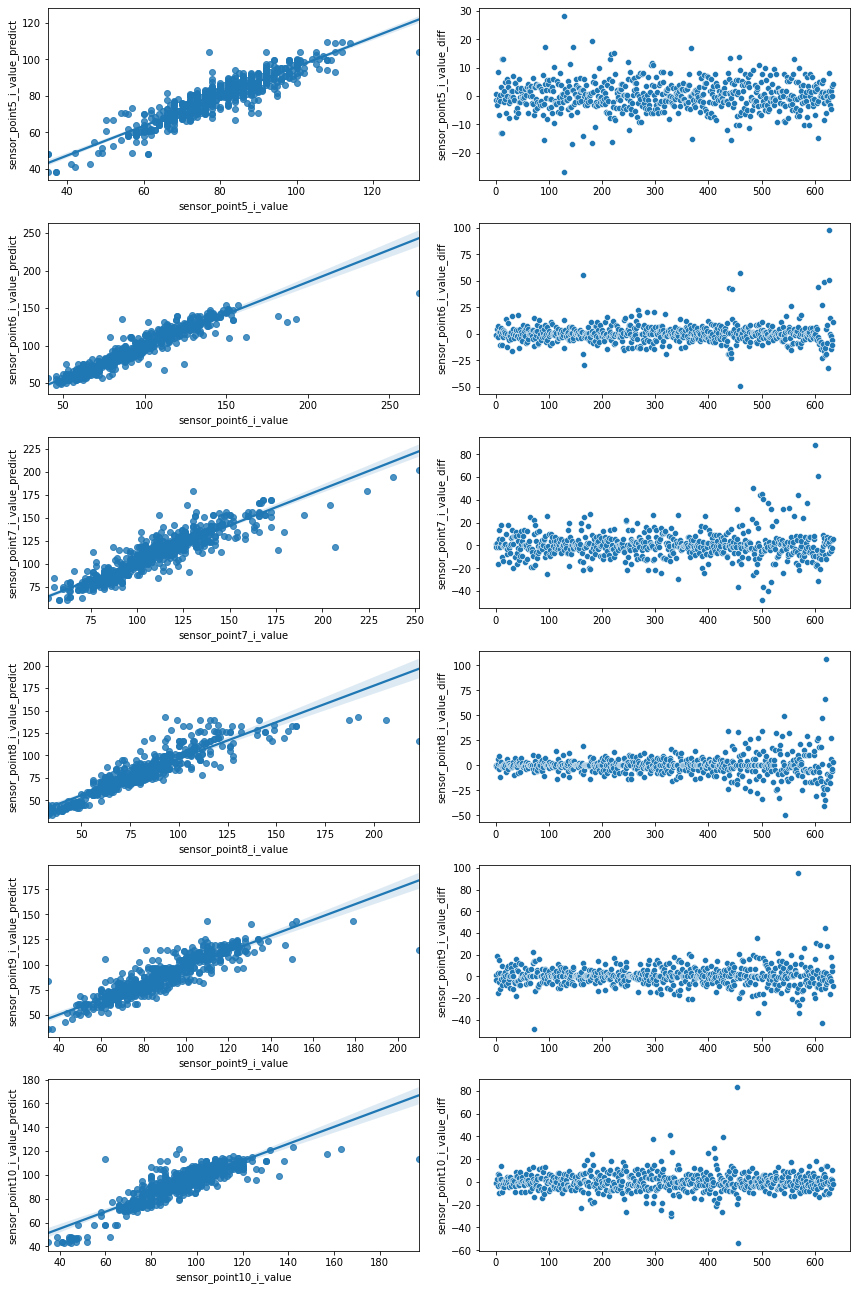

In [46]:
# 計算實際值跟預測值差異

data_T = Model_result # 資料類型
Model_ch = 'XGB' # 選擇 model

Y_predict_diff = data_y # 創建起始Table
for i in range(6):
    Y_predict_diff[data_y.columns.tolist()[i] + '_predict'] = data_T[Model_ch + '_' + data_y.columns.tolist()[i]]
    Y_predict_diff[data_y.columns.tolist()[i] + '_diff'] = data_T['Actual_' + data_y.columns.tolist()[i]]\
                                                            - data_T[Model_ch + '_' + data_y.columns.tolist()[i]]
# display(Y_predict_diff)

# seaborn呈現結果
fig, axes = plt.subplots(6, 2, figsize=(12, 18))

for i in range(6):
    # 預測值跟實際值分布狀況
    sns.regplot(x = data_y.columns.tolist()[i], 
                y = data_y.columns.tolist()[i] + '_predict', 
                data = Y_predict_diff, 
                ax=axes[i, 0])
    
    # 每筆資料的差異
    sns.scatterplot(x = Y_predict_diff.index,
                    y = data_y.columns.tolist()[i] + '_diff',
                    data = Y_predict_diff, 
                    ax=axes[i, 1])
    
    
plt.tight_layout()